# Notebook 6: Trying with last periodicity of 1

# Data

The data is downloaded from NATIONAL CENTRE FOR POLAR AND OCEAN RESEARCH, India: http://data.ncaor.gov.in/newhtml

# Dataset Info

In [1]:
with open('b_imdncpor_synoptic.txt') as f:
    print(' '.join(f.readlines()))


 ----------------------Synoptic Data-------------------------------------------------------------------
 
 Measurements/ data	: Synoptic
 Parameters		: Observation Time,  wind direction, wind speed, temparature, MSLP
 Duration		: 05-05-2016 to	02-08-2021
 Location		: Bharati
 Latitude and Longitude	: 69Â°24.41'S, 76Â°11.72'E
 Data file format	: ASCII
 
 ------------------------------------------------------------------------------------------------------
 
 
 



In [2]:
import seaborn as sns
from matplotlib import pyplot as plt
import pandas as pd
import numpy as np

In [3]:
df = pd.read_csv('synoptic_bharati.csv')
df.Time = pd.to_datetime(df.Time)
df.head()

,Time,WindDirection,WindSpeed,Temperature,Pressure
0,2016-05-01 00:00:00,5,8.0,-21.5,981.1
1,2016-05-22 00:00:00,0,0.0,-19.4,986.1
2,2016-05-22 06:00:00,9,10.0,-16.6,980.4
3,2016-05-22 12:00:00,9,9.0,-17.4,973.4
4,2016-05-22 18:00:00,5,13.0,-17.4,970.7


In [4]:
min_time = df.Time.min()
max_time = df.Time.max()
weather_data = pd.DataFrame(pd.date_range(min_time,max_time, freq='6H'), columns=['Time'])
weather_data.head()

,Time
0,2016-05-01 00:00:00
1,2016-05-01 06:00:00
2,2016-05-01 12:00:00
3,2016-05-01 18:00:00
4,2016-05-02 00:00:00


https://pandas.pydata.org/pandas-docs/stable/user_guide/timeseries.html#offset-aliases

https://pandas.pydata.org/docs/reference/api/pandas.DataFrame.asfreq.html

In [5]:
weather_data = pd.merge(weather_data, df, on='Time', how='left')
weather_data.isna().sum()

Time                0
WindDirection    1906
WindSpeed        2013
Temperature      1922
Pressure         2268
dtype: int64

In [6]:
weather_data = weather_data.loc[2715:6000] # Through manual inspection and checking

Using Temperature data to forecast future temperature.

In [7]:
temp_df = weather_data[['Temperature']].copy()
temp_df.head()

,Temperature
2715,-14.6
2716,-17.2
2717,-14.0
2718,-15.5
2719,-16.8


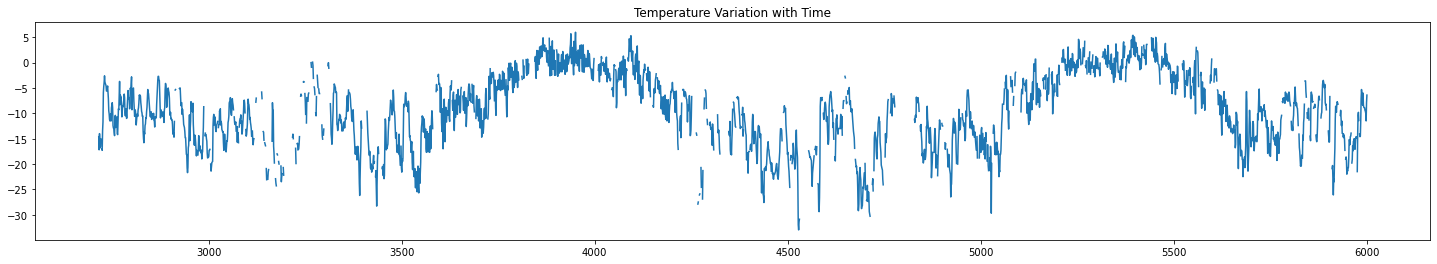

In [8]:
weather_data.Temperature.plot(figsize=(25,4), title='Temperature Variation with Time')
plt.show()

We can see highest temperature around january and lowet temperatures around July to October.

In [9]:
def simple_x_y_splitter(dataframe, col, prev_n_days=[]):
    df = dataframe.copy()
    for lag in prev_n_days:
        df[f'lag_{lag}'] = df[col].shift(lag)
    df.dropna(inplace=True)
    y = df[col].values
    X = df.drop([col], axis=1).values
    return np.expand_dims(X,2), y

In [10]:
X, y = simple_x_y_splitter(temp_df, 'Temperature',prev_n_days=[1])

In [11]:
y

array([-17.2, -14. , -15.5, ..., -11.5,  -7.9,  -6.4])

In [12]:
X

array([[[-14.6]],

       [[-17.2]],

       [[-14. ]],

       ...,

       [[-10. ]],

       [[-11.5]],

       [[ -7.9]]])

In [13]:
y.shape

(2460,)

# Temporal splitting

In [14]:
train_val_split_idx, val_test_split_idx = int(X.shape[0]*.7), int(X.shape[0]*.85)
print(train_val_split_idx, val_test_split_idx)
X_train, y_train = X[:train_val_split_idx], y[:train_val_split_idx]
X_val, y_val = X[train_val_split_idx:val_test_split_idx], y[train_val_split_idx:val_test_split_idx]
X_test, y_test = X[val_test_split_idx:], y[val_test_split_idx:]

1722 2091


# Standardization

In [15]:
X_train_mean = X_train.mean()
X_train_sd= X_train.std()
y_train_mean = y_train.mean()
y_train_sd= y_train.std()

def standardize(x, y):
    x_std = (x-X_train_mean)/X_train_sd
    y_std = (y-y_train_mean)/y_train_sd
    return x_std, y_std

X_train_std, y_train_std = standardize(X_train, y_train)
X_val_std, y_val_std = standardize(X_val, y_val)
X_test_std, y_test_std = standardize(X_test, y_test)

# LSTM Model 1

In [16]:
from tensorflow.keras.layers import *
from tensorflow.keras.models import Sequential
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import ModelCheckpoint
from tensorflow.keras.losses import MeanSquaredError
from tensorflow.keras.metrics import RootMeanSquaredError

In [17]:
from tensorflow.keras.callbacks import TensorBoard

tb1 = TensorBoard(
    log_dir='logs6',
    histogram_freq=0,
    write_graph=True,
    write_images=False,
    write_steps_per_second=False,
    update_freq='epoch',
    profile_batch=0,
    embeddings_freq=0,
    embeddings_metadata=None
)

In [18]:
model1 = Sequential()
model1.add(InputLayer((1,1)))
model1.add(LSTM(64))
model1.add(Dense(8,'relu'))
model1.add(Dense(1,'linear'))
model1.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, 64)                16896     
                                                                 
 dense (Dense)               (None, 8)                 520       
                                                                 
 dense_1 (Dense)             (None, 1)                 9         
                                                                 
Total params: 17,425
Trainable params: 17,425
Non-trainable params: 0
_________________________________________________________________


In [19]:
cp1 = ModelCheckpoint('model6/', save_best_only=True)
model1.compile(loss=MeanSquaredError(), optimizer=Adam(learning_rate=0.001), metrics=[RootMeanSquaredError()])

In [20]:
model1.fit(X_train, y_train, validation_data=(X_val, y_val), epochs=50, callbacks=[cp1, tb1])

Epoch 1/50
47/54 [=========================>....] - ETA: 0s - loss: 134.8702 - root_mean_squared_error: 11.6134

INFO:tensorflow:Assets written to: model6\assets


INFO:tensorflow:Assets written to: model6\assets


54/54 [==============================] - 67s 993ms/step - loss: 130.3963 - root_mean_squared_error: 11.4191 - val_loss: 17.6030 - val_root_mean_squared_error: 4.1956
Epoch 2/50
53/54 [============================>.] - ETA: 0s - loss: 54.5460 - root_mean_squared_error: 7.3855

INFO:tensorflow:Assets written to: model6\assets


INFO:tensorflow:Assets written to: model6\assets


54/54 [==============================] - 48s 904ms/step - loss: 53.8688 - root_mean_squared_error: 7.3395 - val_loss: 7.0004 - val_root_mean_squared_error: 2.6458
Epoch 3/50
54/54 [==============================] - 1s 10ms/step - loss: 12.5995 - root_mean_squared_error: 3.5496 - val_loss: 7.0060 - val_root_mean_squared_error: 2.6469
Epoch 4/50
53/54 [============================>.] - ETA: 0s - loss: 8.6117 - root_mean_squared_error: 2.9346

INFO:tensorflow:Assets written to: model6\assets


INFO:tensorflow:Assets written to: model6\assets


54/54 [==============================] - 26s 485ms/step - loss: 8.5811 - root_mean_squared_error: 2.9293 - val_loss: 5.1471 - val_root_mean_squared_error: 2.2687
Epoch 5/50
51/54 [===========================>..] - ETA: 0s - loss: 6.5932 - root_mean_squared_error: 2.5677

INFO:tensorflow:Assets written to: model6\assets


INFO:tensorflow:Assets written to: model6\assets


54/54 [==============================] - 23s 432ms/step - loss: 6.4873 - root_mean_squared_error: 2.5470 - val_loss: 4.5659 - val_root_mean_squared_error: 2.1368
Epoch 6/50
47/54 [=========================>....] - ETA: 0s - loss: 5.6401 - root_mean_squared_error: 2.3749

INFO:tensorflow:Assets written to: model6\assets


INFO:tensorflow:Assets written to: model6\assets


54/54 [==============================] - 30s 569ms/step - loss: 5.6124 - root_mean_squared_error: 2.3691 - val_loss: 4.3977 - val_root_mean_squared_error: 2.0971
Epoch 7/50
54/54 [==============================] - ETA: 0s - loss: 5.2533 - root_mean_squared_error: 2.2920

INFO:tensorflow:Assets written to: model6\assets


INFO:tensorflow:Assets written to: model6\assets


54/54 [==============================] - 20s 385ms/step - loss: 5.2533 - root_mean_squared_error: 2.2920 - val_loss: 4.3097 - val_root_mean_squared_error: 2.0760
Epoch 8/50
53/54 [============================>.] - ETA: 0s - loss: 5.0918 - root_mean_squared_error: 2.2565

INFO:tensorflow:Assets written to: model6\assets


INFO:tensorflow:Assets written to: model6\assets


54/54 [==============================] - 18s 335ms/step - loss: 5.0702 - root_mean_squared_error: 2.2517 - val_loss: 4.2581 - val_root_mean_squared_error: 2.0635
Epoch 9/50
46/54 [========================>.....] - ETA: 0s - loss: 4.8939 - root_mean_squared_error: 2.2122

INFO:tensorflow:Assets written to: model6\assets


INFO:tensorflow:Assets written to: model6\assets


54/54 [==============================] - 16s 301ms/step - loss: 4.9139 - root_mean_squared_error: 2.2167 - val_loss: 4.1649 - val_root_mean_squared_error: 2.0408
Epoch 10/50
48/54 [=========================>....] - ETA: 0s - loss: 4.9297 - root_mean_squared_error: 2.2203

INFO:tensorflow:Assets written to: model6\assets


INFO:tensorflow:Assets written to: model6\assets


54/54 [==============================] - 15s 287ms/step - loss: 4.8606 - root_mean_squared_error: 2.2047 - val_loss: 4.1350 - val_root_mean_squared_error: 2.0335
Epoch 11/50
49/54 [==========================>...] - ETA: 0s - loss: 4.6285 - root_mean_squared_error: 2.1514

INFO:tensorflow:Assets written to: model6\assets


INFO:tensorflow:Assets written to: model6\assets


54/54 [==============================] - 20s 383ms/step - loss: 4.7463 - root_mean_squared_error: 2.1786 - val_loss: 4.0932 - val_root_mean_squared_error: 2.0232
Epoch 12/50
54/54 [==============================] - 0s 9ms/step - loss: 4.6988 - root_mean_squared_error: 2.1677 - val_loss: 4.1371 - val_root_mean_squared_error: 2.0340
Epoch 13/50
48/54 [=========================>....] - ETA: 0s - loss: 4.5930 - root_mean_squared_error: 2.1431

INFO:tensorflow:Assets written to: model6\assets


INFO:tensorflow:Assets written to: model6\assets


54/54 [==============================] - 22s 412ms/step - loss: 4.6330 - root_mean_squared_error: 2.1524 - val_loss: 4.0638 - val_root_mean_squared_error: 2.0159
Epoch 14/50
48/54 [=========================>....] - ETA: 0s - loss: 4.5127 - root_mean_squared_error: 2.1243

INFO:tensorflow:Assets written to: model6\assets


INFO:tensorflow:Assets written to: model6\assets


54/54 [==============================] - 21s 390ms/step - loss: 4.5907 - root_mean_squared_error: 2.1426 - val_loss: 4.0593 - val_root_mean_squared_error: 2.0148
Epoch 15/50
54/54 [==============================] - 0s 8ms/step - loss: 4.5818 - root_mean_squared_error: 2.1405 - val_loss: 4.0921 - val_root_mean_squared_error: 2.0229
Epoch 16/50
54/54 [==============================] - 1s 14ms/step - loss: 4.5451 - root_mean_squared_error: 2.1319 - val_loss: 4.1465 - val_root_mean_squared_error: 2.0363
Epoch 17/50
54/54 [==============================] - 0s 9ms/step - loss: 4.5035 - root_mean_squared_error: 2.1221 - val_loss: 4.0621 - val_root_mean_squared_error: 2.0155
Epoch 18/50
54/54 [==============================] - 0s 8ms/step - loss: 4.4921 - root_mean_squared_error: 2.1195 - val_loss: 4.1323 - val_root_mean_squared_error: 2.0328
Epoch 19/50
54/54 [==============================] - 0s 9ms/step - loss: 4.4725 - root_mean_squared_error: 2.1148 - val_loss: 4.1183 - val_root_mean_squa

INFO:tensorflow:Assets written to: model6\assets


INFO:tensorflow:Assets written to: model6\assets


54/54 [==============================] - 26s 499ms/step - loss: 4.4554 - root_mean_squared_error: 2.1108 - val_loss: 3.9898 - val_root_mean_squared_error: 1.9974
Epoch 21/50
54/54 [==============================] - 1s 11ms/step - loss: 4.4356 - root_mean_squared_error: 2.1061 - val_loss: 4.1628 - val_root_mean_squared_error: 2.0403
Epoch 22/50
51/54 [===========================>..] - ETA: 0s - loss: 4.3412 - root_mean_squared_error: 2.0836

INFO:tensorflow:Assets written to: model6\assets


INFO:tensorflow:Assets written to: model6\assets


54/54 [==============================] - 33s 631ms/step - loss: 4.4362 - root_mean_squared_error: 2.1062 - val_loss: 3.9688 - val_root_mean_squared_error: 1.9922
Epoch 23/50
54/54 [==============================] - 1s 13ms/step - loss: 4.4130 - root_mean_squared_error: 2.1007 - val_loss: 4.1783 - val_root_mean_squared_error: 2.0441
Epoch 24/50
54/54 [==============================] - 0s 9ms/step - loss: 4.4192 - root_mean_squared_error: 2.1022 - val_loss: 3.9765 - val_root_mean_squared_error: 1.9941
Epoch 25/50
54/54 [==============================] - 0s 9ms/step - loss: 4.4575 - root_mean_squared_error: 2.1113 - val_loss: 4.0496 - val_root_mean_squared_error: 2.0124
Epoch 26/50
54/54 [==============================] - 1s 10ms/step - loss: 4.3848 - root_mean_squared_error: 2.0940 - val_loss: 4.0564 - val_root_mean_squared_error: 2.0141
Epoch 27/50
54/54 [==============================] - 0s 8ms/step - loss: 4.3966 - root_mean_squared_error: 2.0968 - val_loss: 4.0140 - val_root_mean_squ

INFO:tensorflow:Assets written to: model6\assets


INFO:tensorflow:Assets written to: model6\assets


54/54 [==============================] - 22s 411ms/step - loss: 4.3532 - root_mean_squared_error: 2.0864 - val_loss: 3.9495 - val_root_mean_squared_error: 1.9873
Epoch 29/50
54/54 [==============================] - 0s 9ms/step - loss: 4.4043 - root_mean_squared_error: 2.0986 - val_loss: 4.1719 - val_root_mean_squared_error: 2.0425
Epoch 30/50
54/54 [==============================] - 1s 10ms/step - loss: 4.3816 - root_mean_squared_error: 2.0932 - val_loss: 4.1258 - val_root_mean_squared_error: 2.0312
Epoch 31/50
54/54 [==============================] - 0s 9ms/step - loss: 4.3645 - root_mean_squared_error: 2.0891 - val_loss: 4.0969 - val_root_mean_squared_error: 2.0241
Epoch 32/50
54/54 [==============================] - ETA: 0s - loss: 4.3373 - root_mean_squared_error: 2.0826

INFO:tensorflow:Assets written to: model6\assets


INFO:tensorflow:Assets written to: model6\assets


54/54 [==============================] - 15s 276ms/step - loss: 4.3373 - root_mean_squared_error: 2.0826 - val_loss: 3.9479 - val_root_mean_squared_error: 1.9869
Epoch 33/50
54/54 [==============================] - 0s 7ms/step - loss: 4.3606 - root_mean_squared_error: 2.0882 - val_loss: 4.1664 - val_root_mean_squared_error: 2.0412
Epoch 34/50
54/54 [==============================] - 0s 6ms/step - loss: 4.3904 - root_mean_squared_error: 2.0953 - val_loss: 4.1079 - val_root_mean_squared_error: 2.0268
Epoch 35/50
54/54 [==============================] - 0s 6ms/step - loss: 4.3303 - root_mean_squared_error: 2.0809 - val_loss: 4.2340 - val_root_mean_squared_error: 2.0577
Epoch 36/50
54/54 [==============================] - 0s 8ms/step - loss: 4.3505 - root_mean_squared_error: 2.0858 - val_loss: 4.0445 - val_root_mean_squared_error: 2.0111
Epoch 37/50
54/54 [==============================] - 0s 8ms/step - loss: 4.3688 - root_mean_squared_error: 2.0902 - val_loss: 4.0831 - val_root_mean_squar

In [21]:
def post_process(y):
    return (X_train_sd*y)+X_train_mean

In [22]:
from tensorflow.keras.models import load_model
model1 = load_model('model6/')

In [23]:
predicted_test_df = pd.DataFrame({'Predicted Temperature':post_process(model1.predict(X_test_std).flatten()), 'Actual Temperature': y_test})
predicted_val_df = pd.DataFrame({'Predicted Temperature':post_process(model1.predict(X_val_std).flatten()), 'Actual Temperature': y_val})
predicted_train_df = pd.DataFrame({'Predicted Temperature':post_process(model1.predict(X_train_std).flatten()), 'Actual Temperature': y_train})

54/54 [==============================] - 0s 4ms/step


In [24]:
from sklearn.metrics import mean_squared_error

<AxesSubplot:title={'center':'RMSE: 3.0935986383388596'}>

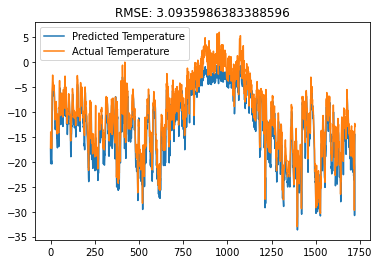

In [25]:
predicted_train_df.plot(title=f"RMSE: {mean_squared_error(predicted_train_df['Actual Temperature'], predicted_train_df['Predicted Temperature'], squared=False)}")

<AxesSubplot:title={'center':'RMSE:3.487082748436073'}>

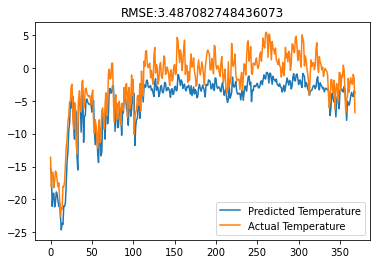

In [26]:
predicted_val_df.plot(title = f"RMSE:{mean_squared_error(predicted_val_df['Actual Temperature'], predicted_val_df['Predicted Temperature'], squared=False)}")

<AxesSubplot:title={'center':'RMSE:3.33462725343717'}>

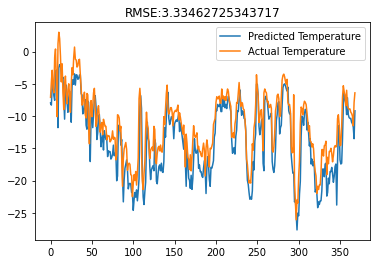

In [27]:
predicted_test_df.plot(title = f"RMSE:{mean_squared_error(predicted_test_df['Actual Temperature'], predicted_test_df['Predicted Temperature'], squared=False)}")


In [28]:
y.shape

(2460,)

In [79]:
test = np.expand_dims(np.arange(-50,50,.01),1)

In [80]:
test_out = model1.predict([test])

313/313 [==============================] - 1s 5ms/step


In [81]:
one_one_df = pd.DataFrame({'inp':test.flatten(),'out':post_process(test_out.flatten())})

<AxesSubplot:xlabel='inp', ylabel='out'>

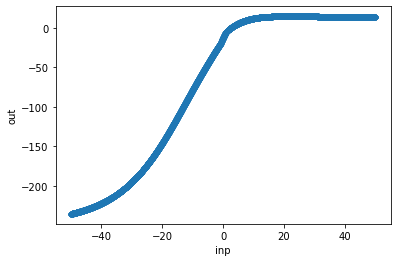

In [82]:
one_one_df.plot(kind='scatter', x='inp',y='out')

Why is LSTM predicting outputs when the input is just previous temperature. No time or date is given. How can it possibly know to go up or down?